In [1]:
%matplotlib inline
import sys
import os
import random
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path + "/src/simulations_v2")
from load_params import load_multigroup_params, load_params
from dynamic_population_sim import DynamicPopulationSim
from multi_group_simulation_dynamic_population import MultiGroupSimulationDynamicPopulation
import pandas as pd
from util_functions import *
from uncertainty_analysis import *
from sim_helper_functions import *
from plot_utils import *
configure_plot(plt)

from math import sqrt
from analysis_helpers import binomial_exit_function
import gc
gc.collect()
import multiprocessing as mp
mp.cpu_count()

80

In [2]:
from calibrated_student import *
from calibrated_FS import *

/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


In [4]:
def get_calibrated_trajs(ntrajs):
    student_results = sample_student_trajectories(ntrajs)
    FS_results = sample_FS_trajectories(ntrajs)
    return_list = list()
    for list_dfs, FS_df in zip(student_results, FS_results):
        list_dfs.extend([FS_df])
        return_list.append(list_dfs)
    return return_list

In [5]:
get_calibrated_trajs(2)

[[        S  QS  QI  R E_0 E_1 E_2 E_3 E_4 E_5  ... SyID_severe_13  \
  0    3533   0   0  0   0   0   0   0   0   0  ...              0   
  1    3636   0   0  0   0   0   0   0   0   0  ...              0   
  2    3860   0   0  0   0   0   0   0   0   0  ...              0   
  3    3961   0   0  0   0   0   0   0   0   0  ...              0   
  4    4054   0   0  0   0   0   0   0   0   0  ...              0   
  ..    ...  ..  .. ..  ..  ..  ..  ..  ..  ..  ...            ...   
  96   8720  11  48  2   0   0   0   0   0   0  ...              0   
  97   8721  10  48  2   0   0   0   0   0   0  ...              0   
  98   8721  10  48  2   0   0   0   0   0   0  ...              0   
  99   8721  10  48  2   0   0   0   0   0   0  ...              0   
  100  8721  10  48  2   0   0   0   0   0   0  ...              0   
  
      SyID_severe_14 SyID_severe_15 SyID_severe_16 SyID_severe_17  \
  0                0              0              0              0   
  1                

# Student Calibration Code

In [2]:

movein_selfiso_params = load_params('../../src/simulations_v2/params/quarantine_analysis/oct12quarantine/ug_self_iso.yaml')[1]



g1_base_params_free  = load_params('../../src/simulations_v2/params/apr7calibration/group_1_students_pre_semester_private.yaml')[1]
g1_base_params_post_movein = load_params('../../src/simulations_v2/params/apr7calibration/group_1_students_post_movein_private.yaml')[1]

g2_base_params_free  = load_params('../../src/simulations_v2/params/apr7calibration/group_2_students_pre_semester_private.yaml')[1]
g2_base_params_post_movein = load_params('../../src/simulations_v2/params/apr7calibration/group_2_students_post_movein_private.yaml')[1]


g3_base_params_free  = load_params('../../src/simulations_v2/params/apr7calibration/group_3_students_pre_semester_private.yaml')[1]
g3_base_params_post_movein = load_params('../../src/simulations_v2/params/apr7calibration/group_3_students_post_movein_private.yaml')[1]

#Load Actuals

actuals1 = pd.read_csv('../../src/simulations_v2/params/apr7calibration/actual_counts_group_1.csv')
actuals2 = pd.read_csv('../../src/simulations_v2/params/apr7calibration/actual_counts_group_2.csv')
actuals3 = pd.read_csv('../../src/simulations_v2/params/apr7calibration/actual_counts_group_3.csv')


actual_counts1 = actuals1['cum_case_count']
actual_counts2 = actuals2['cum_case_count']
actual_counts3 = actuals3['cum_case_count']


g1_movein_contact_matrix = np.matrix([
    [g1_base_params_free['expected_contacts_per_day'], 0],
    [0, 0]])

g2_movein_contact_matrix = np.matrix(
   [ [g2_base_params_free['expected_contacts_per_day'], 0],
    [0, 0]])

g3_movein_contact_matrix = np.matrix(
   [ [g3_base_params_free['expected_contacts_per_day'], 0],
    [0, 0]])

g1_base_params_post_movein['severe_symptoms_daily_self_report_p'] = 0.36
g2_base_params_post_movein['severe_symptoms_daily_self_report_p'] = 0.36
g3_base_params_post_movein['severe_symptoms_daily_self_report_p'] = 0.36

/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


In [3]:

def sample_movein_trajectory(transmission_p):
    
    movein_time_horizon = 18

    init_pop_count = 485
    avg_init_cases = 5.77
    new_population_counts = [int(count) for count in """103
    224
    101
    93
    90
    70
    117
    442
    462
    125
    281
    77
    206
    100
    228
    89
    106
    134""".split('\n')]

    infxn_prob = avg_init_cases / (sum(new_population_counts) + init_pop_count)



    g1_free_group_population_dynamics = {}
    movein_time_horizon = 18 # 8/16 through 9/2
    new_case_exposed_rate = 1
    for t in range(movein_time_horizon):
        new_pop = new_population_counts[t]
        new_cases = np.random.binomial(new_pop, infxn_prob)
        new_exposed = np.random.binomial(new_cases, new_case_exposed_rate)
        g1_free_group_population_dynamics[t] = {'S': new_pop - new_exposed, 'E': new_exposed, 'ID': new_cases- new_exposed}



    init_pop_count = 1159
    avg_init_cases = 3.37
    new_population_counts = [int(count) for count in """245
    535
    240
    222
    215
    167
    280
    1055
    1103
    298
    671
    183
    493
    238
    546
    211
    252
    321""".split('\n')]

    infxn_prob = avg_init_cases / (sum(new_population_counts) + init_pop_count)



    g2_free_group_population_dynamics = {}
    movein_time_horizon = 18 # 8/16 through 9/2
    new_case_exposed_rate = 1
    for t in range(movein_time_horizon):
        new_pop = new_population_counts[t]
        new_cases = np.random.binomial(new_pop, infxn_prob)
        new_exposed = np.random.binomial(new_cases, new_case_exposed_rate)
        g2_free_group_population_dynamics[t] = {'S': new_pop - new_exposed, 'E': new_exposed, 'ID': new_cases- new_exposed}


    init_pop_count = 5171
    avg_init_cases = 0
    new_population_counts = [int(count) for count in """52
    69
    45
    57
    103
    59
    65
    63
    55
    47
    41
    31
    25
    48
    40
    45
    38
    147""".split('\n')]

    infxn_prob = avg_init_cases / (sum(new_population_counts) + init_pop_count)



    g3_free_group_population_dynamics = {}
    movein_time_horizon = 18 # 8/16 through 9/2
    new_case_exposed_rate = 1
    for t in range(movein_time_horizon):
        new_pop = new_population_counts[t]
        new_cases = np.random.binomial(new_pop, infxn_prob)
        new_exposed = np.random.binomial(new_cases, new_case_exposed_rate)
        g3_free_group_population_dynamics[t] = {'S': new_pop - new_exposed, 'E': new_exposed, 'ID': new_cases- new_exposed}
    
    
    
    g1_base_params_free['exposed_infection_p'] = transmission_p
    g1_base_params_post_movein['exposed_infection_p'] = transmission_p
    g2_base_params_free['exposed_infection_p'] = transmission_p
    g2_base_params_post_movein['exposed_infection_p'] = transmission_p
    g3_base_params_free['exposed_infection_p'] = transmission_p
    g3_base_params_post_movein['exposed_infection_p'] = transmission_p
    
    
    g1_base_params_free['sample_QI_exit_function'] = binomial_exit_function(0)
    g1_base_params_post_movein['sample_QI_exit_function'] = binomial_exit_function(0)

    g2_base_params_free['sample_QI_exit_function'] = binomial_exit_function(0)
    g2_base_params_post_movein['sample_QI_exit_function'] = binomial_exit_function(0)

    g3_base_params_free['sample_QI_exit_function'] = binomial_exit_function(0)
    g3_base_params_post_movein['sample_QI_exit_function'] = binomial_exit_function(0)

    
    dynamic_pop_sim1 = DynamicPopulationSim(
        g1_base_params_free,
        movein_selfiso_params,
        g1_base_params_post_movein,
        g1_movein_contact_matrix,
        movein_time_horizon,
        g1_free_group_population_dynamics,
        {}
    )

    dynamic_pop_sim2 = DynamicPopulationSim(
        g2_base_params_free,
        movein_selfiso_params,
        g2_base_params_post_movein,
        g2_movein_contact_matrix,
        movein_time_horizon,
        g2_free_group_population_dynamics,
        {}
    )

    dynamic_pop_sim3 = DynamicPopulationSim(
        g3_base_params_free,
        movein_selfiso_params,
        g3_base_params_post_movein,
        g3_movein_contact_matrix,
        movein_time_horizon,
        g3_free_group_population_dynamics,
        {}
    )
    
    
    contact_matrix = np.matrix([[0.736, 0.023, 0],[.028, .148, 0], [0, 0.023, .067]])
    
    
    multigroup_sim = MultiGroupSimulationDynamicPopulation([dynamic_pop_sim1, dynamic_pop_sim2,dynamic_pop_sim3], contact_matrix)
    for _ in range(0,len(actual_counts1)-1):
        multigroup_sim.step()

    movein_df = dynamic_pop_sim1.movein_sim.sims[0].sim_df
    post_movein_df = dynamic_pop_sim1.post_movein_sim.sim_df
    post_movein_df.index = range(movein_df.shape[0]-1, post_movein_df.shape[0] + movein_df.shape[0] -1)
    df = pd.concat([movein_df, post_movein_df[1:]])
    r1 = list(df['QI'])
    
    movein_df = dynamic_pop_sim2.movein_sim.sims[0].sim_df
    post_movein_df = dynamic_pop_sim2.post_movein_sim.sim_df
    post_movein_df.index = range(movein_df.shape[0]-1, post_movein_df.shape[0] + movein_df.shape[0] -1)
    df = pd.concat([movein_df, post_movein_df[1:]])
    r2 = list(df['QI'])
    
    movein_df = dynamic_pop_sim3.movein_sim.sims[0].sim_df
    post_movein_df = dynamic_pop_sim3.post_movein_sim.sim_df
    post_movein_df.index = range(movein_df.shape[0]-1, post_movein_df.shape[0] + movein_df.shape[0] -1)
    df = pd.concat([movein_df, post_movein_df[1:]])
    r3 = list(df['QI'])
    
    return [r1,r2,r3]

def sample_trajectories(transmission_p, ntrajectories):
    print(transmission_p)
    g1_trajectories = []
    g2_trajectories = []
    g3_trajectories = []
    for _ in range(ntrajectories):
        t =sample_movein_trajectory(transmission_p)
        g1_trajectories.append(t[0])
        g2_trajectories.append(t[1])
        g3_trajectories.append(t[2])
    return [g1_trajectories,g2_trajectories,g3_trajectories]


def score_trajectories_average(list_of_trajectories):
    g1_trajectories_avg = np.mean(list_of_trajectories[0],axis = 0)
    g2_trajectories_avg = np.mean(list_of_trajectories[1],axis = 0)
    g3_trajectories_avg = np.mean(list_of_trajectories[2],axis = 0)
    
    sum_of_squares = 0
    for i in range(0,len(g1_trajectories_avg)):
        sum_of_squares = sum_of_squares + (g1_trajectories_avg[i]-actual_counts1[i])**2
        sum_of_squares = sum_of_squares + (g2_trajectories_avg[i]-actual_counts2[i])**2
        sum_of_squares = sum_of_squares + (g3_trajectories_avg[i]-actual_counts3[i])**2
    
    return   sum_of_squares/ len(g1_trajectories_avg) 
    


In [4]:
# from analysis_helpers import binomial_exit_function
# from dynamic_population_sim import DynamicPopulationSim
# from multi_group_simulation_dynamic_population import MultiGroupSimulationDynamicPopulation
student_trajectories = sample_trajectories(0.525, 100)

0.525


In [5]:
# Average calibrated student trajectory
g1_avg_trajs = list()
for g1_traj in student_trajectories[0]:
    g1_avg_trajs.append(get_cum_inf_trajectory(g1_traj))
g1_avg_traj = np.mean(g1_avg_trajs, axis=0)

g2_avg_trajs = list()
for g2_traj in student_trajectories[1]:
    g2_avg_trajs.append(get_cum_inf_trajectory(g2_traj))
g2_avg_traj = np.mean(g2_avg_trajs, axis=0)

g3_avg_trajs = list()
for g3_traj in student_trajectories[2]:
    g3_avg_trajs.append(get_cum_inf_trajectory(g3_traj))
g3_avg_traj = np.mean(g3_avg_trajs, axis=0)

TypeError: list indices must be integers or slices, not list

In [7]:
student_trajectories[0][0]

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 3,
 6,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 9,
 9,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 11,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 14,
 14,
 18,
 22,
 22]

# Faculty / Staff Calibration Code

In [ ]:
base_params_free = load_params('../../src/simulations_v2/params/jan4calibration/faculty_staff_post_movein_private.yaml')[1]
base_params_selfiso = load_params('../../src/simulations_v2/params/quarantine_analysis/oct12quarantine/ug_self_iso.yaml')[1]
base_params_post_movein = load_params('../../src/simulations_v2/params/jan4calibration/faculty_staff_pre_semester_private.yaml')[1]

base_params_free['severe_symptoms_daily_self_report_p'] = 0.36
base_params_selfiso['severe_symptoms_daily_self_report_p'] = 0.36
base_params_post_movein['severe_symptoms_daily_self_report_p'] = 0.36

In [ ]:
outside_infection_week = pd.DataFrame({'week':list(range(34,53)), 'new_weekly_cases':[0,0,0,0,0.000014,0,0,0.000056,0.000097,0.000014,0.000125,0.000083,0.000125,0.000194,0.000167,0.000320,0.000306,0.000264,0.000320]})


In [ ]:
from analysis_helpers import binomial_exit_function
base_params_selfiso['population_size'] = 0
base_params_free['population_size'] = 10283 
base_params_free['test_population_fraction'] = 0 
base_params_free['test_protocol_QFNR'] =.43
# data analysis shows 106 non-"arrival" positives during movein period
# 33 of these were found b/c of symptoms or surveillance
#base_params_free['cases_isolated_per_contact'] = (106 - 33) / 33 
base_params_post_movein['test_population_fraction'] =0.098 #weighted average for students, weighted average for faculty and staff
base_params_free['test_protocol_QFNR'] = .43
base_params_free['daily_outside_infection_p'] = 0
base_params_free['sample_QI_exit_function'] = binomial_exit_function(0)
base_params_post_movein['sample_QI_exit_function'] = binomial_exit_function(0)

init_pop_count = 10283
new_population_counts = [int(count) for count in """0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0""".split('\n')]

movein_contact_matrix = np.matrix(
    [[base_params_free['expected_contacts_per_day'], 0],
    [0, base_params_selfiso['expected_contacts_per_day']]])


def init_movein_sim(transmissions_per_contact, isolations_per_trace=None, outside_infection_week = None):
    avg_init_cases = 0
    infxn_prob = avg_init_cases / (sum(new_population_counts) + init_pop_count)
    base_params = base_params_free.copy()
    init_exposed =  np.random.binomial(init_pop_count, infxn_prob)
    base_params['initial_E_count'] = init_exposed
    base_params['exposed_infection_p'] = transmissions_per_contact
    base_params_post_movein['exposed_infection_p'] = transmissions_per_contact
    base_params_post_movein['outside_infection_p_array'] = outside_infection_week
    
    if isolations_per_trace != None:
        base_params_free['cases_isolated_per_contact'] = isolations_per_trace
        base_params_post_movein['cases_isolated_per_contact']=isolations_per_trace
    free_group_population_dynamics = {}
    movein_time_horizon = 18 # 8/16 through 9/2
    new_case_exposed_rate = 1
    for t in range(movein_time_horizon):
        new_pop = new_population_counts[t]
        new_cases = np.random.binomial(new_pop, infxn_prob)
        new_exposed = np.random.binomial(new_cases, new_case_exposed_rate)
        free_group_population_dynamics[t] = {'S': new_pop - new_exposed, 'E': new_exposed, 'ID': new_cases- new_exposed}
        
    dynamic_pop_sim = DynamicPopulationSim(
        base_params,
        base_params_selfiso,
        base_params_post_movein,
        movein_contact_matrix,
        movein_time_horizon,
        free_group_population_dynamics,
        {}
    )
    return dynamic_pop_sim

In [ ]:
FS_actuals = pd.read_csv('https://raw.githubusercontent.com/peter-i-frazier/group-testing/master/src/simulations_v2/params/jan4calibration/actual_counts_group_4_extended_period.csv')
FS_actual_counts = actuals['cum_case_count']
len(FS_actual_counts)

In [ ]:
def sample_FS_movein_trajectory(transmission_p, isos_per_trace=None,outside_infection_week = None):
    dynamic_pop_sim = init_movein_sim(transmission_p, isos_per_trace,outside_infection_week)
    # for each day
    for i in range(len(actual_counts)-1):
        dynamic_pop_sim.step()
    movein_df = dynamic_pop_sim.movein_sim.sims[0].sim_df
    post_movein_df = dynamic_pop_sim.post_movein_sim.sim_df

    post_movein_df.index = range(movein_df.shape[0]-1, post_movein_df.shape[0] + movein_df.shape[0] -1)
    df = pd.concat([movein_df, post_movein_df[1:]])

    return df

def sample_FS_trajectories(transmission_p, ntrajectories, isos_per_trace=None, outside_infection_week = None):
    trajectories = []
    for _ in range(ntrajectories):
        t = sample_FS_movein_trajectory(transmission_p, isos_per_trace,outside_infection_week)
        trajectories.append(t)
    return trajectories

In [ ]:
staff_trajectories = sample_FS_trajectories(0.011,100,None,outside_infection_week)

# Figures

### Faculty / Staff Calibration Results
Results generated by Brian, improted and plotted in notebook

In [8]:
# importing results
FS_cal_results = pd.read_csv('FS_results_calib_results.csv')
FS_cal_results['log_score'] = np.log(FS_cal_results['score'])
FS_cal_results.sort_values('score',ascending = True)

,Unnamed: 0,transmission_p,score,log_score
9,9,0.011,104.803082,4.652083
10,10,0.012,161.622004,5.085260
8,8,0.010,191.370854,5.254213
7,7,0.009,328.879418,5.795691
11,11,0.013,381.722357,5.944694
6,6,0.008,489.733972,6.193862
5,5,0.007,760.094091,6.633442
4,4,0.006,974.302601,6.881722
3,3,0.005,1154.799393,7.051682
12,12,0.014,1203.584186,7.093059


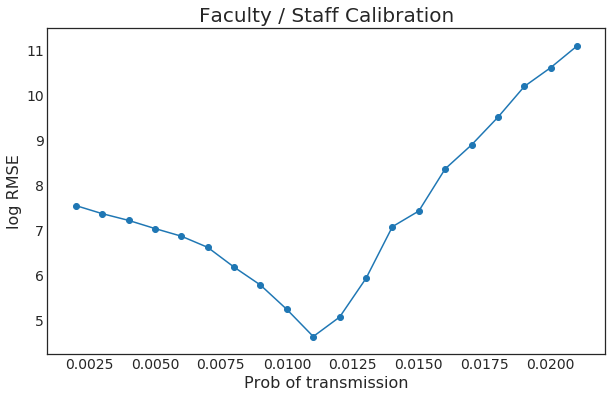

In [9]:
plt.figure(figsize=(10,6))
plt.plot('transmission_p', 'log_score', data=FS_cal_results)
plt.scatter('transmission_p', 'log_score', data=FS_cal_results)

plt.title('Faculty / Staff Calibration')
plt.ylabel('log RMSE')
plt.xlabel('Prob of transmission')

plt.show()

In [17]:
FS_cal_results.sort_values('score',ascending = True)

,Unnamed: 0,transmission_p,score,log_score
9,9,0.011,104.803082,4.652083
10,10,0.012,161.622004,5.085260
8,8,0.010,191.370854,5.254213
7,7,0.009,328.879418,5.795691
11,11,0.013,381.722357,5.944694
6,6,0.008,489.733972,6.193862
5,5,0.007,760.094091,6.633442
4,4,0.006,974.302601,6.881722
3,3,0.005,1154.799393,7.051682
12,12,0.014,1203.584186,7.093059


### Student Calibration Results

In [10]:
student_cal_results = pd.read_csv('../students_to_plot.csv')
student_cal_results

,Unnamed: 0,inputs,RMSE
0,0,0.200,4257.060973
1,1,0.205,4183.392036
2,2,0.210,4118.944084
3,3,0.215,4114.587595
4,4,0.220,4004.727613
...,...,...,...
75,75,0.575,741.298029
76,76,0.580,929.110300
77,77,0.585,976.224232
78,78,0.590,1419.212611


Text(0, 0.5, ' RMSE')

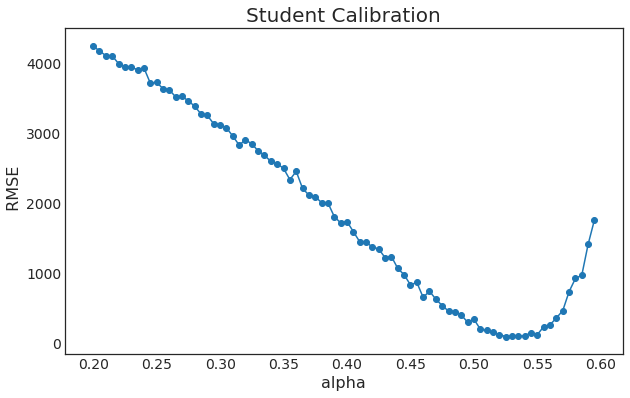

In [11]:
plt.figure(figsize = (10,6))

plt.plot('inputs','RMSE', data=student_cal_results)
plt.scatter('inputs','RMSE', data=student_cal_results)

plt.title('Student Calibration')

plt.xlabel('alpha')
plt.ylabel(' RMSE')